In [277]:
import pandas
import matplotlib
import seaborn
import lifelines
import itertools

from scipy.stats import mannwhitneyu
from cliffsDelta import cliffsDelta

%matplotlib inline

In [341]:
FIG_SIZE = (6, 2.5)

ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist']
DATE_RANGE = pandas.to_datetime('2013-01-01'), pandas.to_datetime('2018-11-30')
CENSOR_DATE = pandas.to_datetime('2018-12-23')

PALETTE = seaborn.color_palette()
COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}
PAL_REL = pandas.np.take(seaborn.color_palette('muted'), [3, 8, 2], axis=0)

SAVEFIG = True

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['legend.framealpha'] = 1
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

patch = lambda c, s: matplotlib.lines.Line2D([0], [0], color=c, linestyle=s)

def _savefig(fig, name):
    import os
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )
    
savefig = _savefig if SAVEFIG else lambda x, y: None

## Dataset

### Load data

In [3]:
df_releases = dict()
df_dependencies = dict()

for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    print('.. releases')
    df_releases[ecosystem] = (
        pandas.read_csv(
            '../data/{}-releases.csv.gz'.format(ecosystem),
            parse_dates=['date'],
            infer_datetime_format=True,
        )
        [lambda d: d['date'] >= pandas.to_datetime('1990-01-01')]
    )
    
    print('.. dependencies')
    df_dependencies[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependencies.csv.gz'.format(ecosystem),
        )
    )
print('Done!')

Loading Cargo
.. releases
.. dependencies
Loading NPM
.. releases
.. dependencies
Loading Packagist
.. releases
.. dependencies
Done!


### Dataset overview

In [4]:
data = pandas.DataFrame(index=['packages', 'releases', 'dependencies', 'first'], columns=ECOSYSTEMS)

for ecosystem in ECOSYSTEMS:
    data.at['packages', ecosystem] = len(df_releases[ecosystem].drop_duplicates(['package']))
    data.at['releases', ecosystem] = len(df_releases[ecosystem].drop_duplicates(['package', 'version']))
    data.at['dependencies', ecosystem] = len(df_dependencies[ecosystem])
    data.at['first', ecosystem] = df_releases[ecosystem]['date'].min()
    
data

,Cargo,NPM,Packagist
packages,20635,880002,142109
releases,113148,5978077,1088909
dependencies,432807,27852013,3079304
first,2014-11-11 00:22:07,2010-11-09 23:36:08,1994-08-23 00:00:00


Our dependency constraints were able to cope with the large majority of dependency constraints. However, some of them could not be parsed. Let's quantify this.
Since the analyses that rely on this preparatory parsing step focus on the latest snapshot of each ecosystem, we only consider this snapshot to quantify this phenomenon.

In [292]:
(
    pandas.concat([
        df_dependencies[ecosystem]
        .sort_values('rank')
        .drop_duplicates('source', keep='last')
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index='ecosystem', columns=['i_empty'], values='target', aggfunc='count', margins=True)
    .assign(prop=lambda d: d[True] / d['All'])
)

i_empty,False,True,All,prop
ecosystem,,,,
Cargo,15051,1,15052,0.000066
NPM,550969,7442,558411,0.013327
Packagist,95909,4083,99992,0.040833
All,661929,11526,673455,0.017115


## How prevalent are 0.y.z?

### Packages in 0.y.z

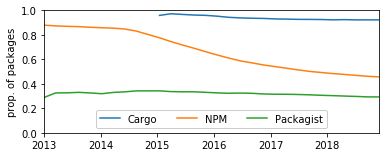

In [171]:
fig, ax = matplotlib.pyplot.subplots()

dates = pandas.date_range(*DATE_RANGE, periods=30)
data = dict()

for ecosystem in ECOSYSTEMS:
    data[ecosystem] = []
    
    _ = df_releases[ecosystem]
    for date in reversed(dates):
        _ = _[lambda d: d['date'] <= date]
        
        data[ecosystem].append((
            date, 
            _.package.nunique(),
            len(_.drop_duplicates('package', keep='last')[lambda d: d['major'] == 0]),
        ))
    
    (
        pandas.DataFrame(data[ecosystem], columns=['date', 'packages', 'zero'])
        .set_index('date')
        .sort_index()
        .assign(**{ecosystem: lambda d: d['zero'] / d['packages']})
        [[ecosystem]]
        .plot(ax=ax, color=COLORS[ecosystem])
    )
    
ax.set(
    xlabel='', 
    xlim=DATE_RANGE,
    ylabel='prop. of packages',
    ylim=(0, 1),
)
ax.legend(loc='lower center', ncol=3)
fig.autofmt_xdate(bottom=0.2, rotation=0, ha='center')

savefig(fig, 'prevalence_packages')    

In [200]:
_ = pandas.concat([
    pandas.DataFrame(data[ecosystem], columns=['date', 'packages', 'zero'])
    .set_index('date')
    .eval('prop = zero / packages')
    .assign(ecosystem=ecosystem)
for ecosystem in ECOSYSTEMS], axis=0)

_.sort_index().iloc[-len(ECOSYSTEMS):]

,packages,zero,prop,ecosystem
date,,,,
2018-11-30,862698,393969,0.456671,NPM
2018-11-30,140971,41307,0.293018,Packagist
2018-11-30,20038,18483,0.922397,Cargo


In [7]:
_.groupby('ecosystem')['prop'].describe()[['mean', 'std', '50%']]

,mean,std,50%
ecosystem,,,
Cargo,0.938949,0.016917,0.932469
NPM,0.667443,0.157789,0.649035
Packagist,0.320228,0.015471,0.323851


Are those 0.y.z abandoned packages? Let's have a look at the proportion of them that were active in 2018.

In [189]:
(
    pandas.concat([
        df_releases[ecosystem]
        .drop_duplicates('package', keep='last')
        .assign(dev=lambda d: d['major'] == 0)
        .assign(active=lambda d: d['date'] >= pandas.to_datetime('2018-01-01'))
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index=['ecosystem', 'dev'], columns=['active'], values='package', aggfunc='count')
    .assign(prop=lambda d: d[True] / (d[True] + d[False]))
)

active            False    True      prop
ecosystem dev                            
Cargo     False     596    1015  0.630043
          True     8409   10615  0.557979
NPM       False  278622  201083  0.419181
          True   279925  120372  0.300707
Packagist False   60537   39971  0.397690
          True    29212   12389  0.297805

And what's the proportion of active packages that are 0.y.z?

In [199]:
(
    pandas.concat([
        df_releases[ecosystem]
        .drop_duplicates('package', keep='last')
        .assign(dev=lambda d: d['major'] == 0)
        .assign(active=lambda d: d['date'] >= pandas.to_datetime('2018-01-01'))
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS], 
        axis=0
    )
    .pivot_table(index=['ecosystem', 'active'], columns=['dev'], values='package', aggfunc='count')
    .assign(prop=lambda d: d[True] / (d[True] + d[False]))
    .xs(True, level='active')
)

dev,False,True,prop
ecosystem,,,
Cargo,1015,10615,0.912726
NPM,201083,120372,0.374460
Packagist,39971,12389,0.236612


### Monthly proportion of 0.y.z updates

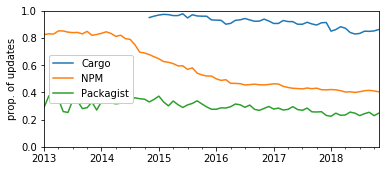

In [85]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_releases[ecosystem]
        .assign(dev=lambda d: d['major'] == 0)
        .groupby([pandas.Grouper(key='date', freq='M'), 'dev'])
        [['version']]
        .count()
        .unstack()['version']
        .assign(total=lambda d: d[True] + d[False])
        .assign(
            zero= lambda d: d[True] / d['total'],
            over= lambda d: d[False] / d['total'],
        )
    )
    
    data[ecosystem]['zero'].rename(ecosystem).plot(ax=ax, color=COLORS[ecosystem])

ax.legend()

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of updates',
    ylim=(0, 1),
)

savefig(fig, 'prevalence_updates')

In [9]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .iloc[-1]
    .rename(ecosystem)
for ecosystem in ECOSYSTEMS], axis=1).loc[['zero', 'total']]

,Cargo,NPM,Packagist
dev,,,
zero,0.863387,0.404944,0.247996
total,4187,160084,13097


## How long does it take to reach 1.0.0?

a.k.a "The 1.0.0 barrier"

### Packages having reached the 1.0.0 barrier

In [337]:
df_temp = dict()

for ecosystem in ECOSYSTEMS:
    df_temp[ecosystem] = (
        df_releases[ecosystem]
        .sort_values('rank_date')
        .pipe(lambda df:
            (
                df
                [lambda d: d['major'] == 0]
                .drop_duplicates('package', keep='first')
                [['package', 'rank', 'date']]
                .merge(
                    (
                        df
                        [lambda d: d['major'] > 0]
                        .drop_duplicates('package', keep='first')
                        [['package', 'rank', 'date']]
                    ),
                    how='outer',
                    on='package',
                    suffixes=('_zero', '_nonzero'),
                )
            )
        )
    )

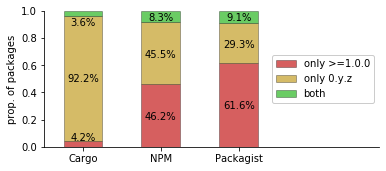

In [275]:
fig, ax = matplotlib.pyplot.subplots()

data = pandas.concat([
    df_temp[ecosystem]
    .assign(no_zero=lambda d: d['date_zero'].isnull())
    .assign(zero_no_one=lambda d: ~d['date_zero'].isnull() & d['date_nonzero'].isnull())
    .assign(zero_and_one=lambda d: ~d['date_zero'].isnull() & ~d['date_nonzero'].isnull())
    [['no_zero', 'zero_no_one', 'zero_and_one']]
    .sum()
    .rename(ecosystem)
    for ecosystem in ECOSYSTEMS], axis=1
)

_ = data.pipe(lambda s: s / s.sum()).T
_.plot.bar(stacked=True, color=PAL_REL, linewidth=1, edgecolor=(0, 0, 0, 0.3), ax=ax)

positions = [(0.07, 0.5, 0.91), (0.22, 0.68, 0.95), (0.30, 0.75, 0.95)]
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, kind in enumerate(['no_zero', 'zero_no_one', 'zero_and_one']):
        ax.annotate('{:.1%}'.format(_.at[ecosystem, kind]), (i, positions[i][j]), ha='center', va='center')

ax.set(
    xlabel='',
    ylabel='prop. of packages',
    xlim=(-0.5, 3.8),
    ylim=(0, 1), 
)

seaborn.despine(fig, top=True, right=True)

# TODO: Add a Venn as legend?

ax.legend(
    ax.get_legend_handles_labels()[0][::1],
    ['only >=1.0.0', 'only 0.y.z', 'both'][::1], 
    loc='center right',
    #title='with releases',
)

ax.xaxis.set_tick_params(rotation=0)

savefig(fig, 'barrier_numbers')

In [111]:
data

,Cargo,NPM,Packagist
no_zero,873,406958,87544
zero_no_one,19024,400297,41601
zero_and_one,738,72747,12964


### Time to reach 1.0.0

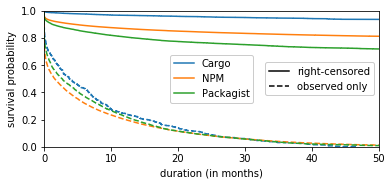

In [344]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    _ = (
        df_temp[ecosystem]
        .dropna(subset=['date_zero'])
        .assign(duration=lambda d: (d['date_nonzero'].fillna(CENSOR_DATE) - d['date_zero']) / pandas.to_timedelta('30 day'))
        .assign(observed=lambda d: ~d['date_nonzero'].isnull())
    )

    
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(_.duration, _.observed, label=ecosystem)
    kmf.plot(ci_show=False, ax=ax, c=COLORS[ecosystem])
    
    
    kmf_ = lifelines.KaplanMeierFitter()
    kmf_.fit(_[_.observed].duration, label='')
    kmf_.plot(ci_show=False, ax=ax, c=COLORS[ecosystem], style='--')
    data[ecosystem] = (kmf, kmf_)
    
ax.set(
    xlim=(0, 50),
    xlabel='duration (in months)',
    ylim=(0, 1),
    ylabel='survival probability'
)

legend = ax.legend(loc='center')
ax.legend(
    [patch('k', '-'), patch('k', '--')],
    ['right-censored', 'observed only'],
    loc='center right',
)
ax.add_artist(legend)

savefig(fig, 'barrier_time')

In [345]:
pandas.concat([
    pandas.concat([
        data[ecosystem][i]
        .survival_function_at_times([1, 3, 6, 12, 18, 24, 36, 48, 60])
        .rename(ecosystem)
        for ecosystem in ECOSYSTEMS
    ], axis=1).rename(columns=lambda x: x + '_' + label)
    for i, label in enumerate(['censored', 'uncensored'])
], axis=1).style.format("{:.2%}")

,Cargo_censored,NPM_censored,Packagist_censored,Cargo_uncensored,NPM_uncensored,Packagist_uncensored
1,98.80%,92.97%,90.82%,68.02%,54.41%,61.42%
3,98.22%,91.12%,87.65%,53.66%,42.90%,48.35%
6,97.74%,89.30%,84.86%,42.95%,32.15%,37.26%
12,96.78%,87.07%,80.90%,24.66%,20.21%,22.59%
18,96.18%,85.56%,78.08%,15.85%,13.27%,13.32%
24,95.61%,84.40%,76.53%,9.76%,8.76%,8.92%
36,94.67%,82.67%,73.78%,3.12%,3.66%,3.10%
48,93.75%,81.46%,72.20%,0.00%,1.40%,1.05%
60,93.75%,80.62%,70.95%,0.00%,0.52%,0.27%


### Updates and time to reach 1.0.0 (observed only)

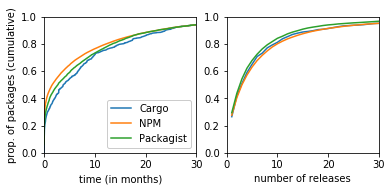

In [346]:
fig, axes = matplotlib.pyplot.subplots(ncols=2, sharex=False, sharey=False)

for ecosystem in ECOSYSTEMS:
    for i, kind in enumerate(['time', 'updates']):
        ax = axes[i]
        (
            df_temp[ecosystem]
            # Remove unobserved event
            .dropna()
            .assign(
                time=lambda d: (d['date_nonzero'] - d['date_zero']) / pandas.to_timedelta('30 day'),
                updates=lambda d: d['rank_nonzero'] - d['rank_zero'],
            )
            .groupby(kind)
            .agg({'package': 'count'})
            .apply(lambda s: s.cumsum() / s.sum())
            .rename(columns={'package': ecosystem})
            .plot(ax=ax, color=COLORS[ecosystem], legend=(i==0))
        )
        
axes[0].set(
    xlim=(0, 30),
    xlabel='time (in months)',
    ylim=(0, 1),
    ylabel='prop. of packages (cumulative)',
)

axes[1].set(
    xlim=(0, 30),
    xlabel='number of releases',
    ylim=(0, 1),
)

savefig(fig, 'barrier_reaching_combined')

In [348]:
pandas.concat([
    df_temp[ecosystem]
    .dropna()
    .assign(
        time=lambda d: (d['date_nonzero'] - d['date_zero']) / pandas.to_timedelta('30 day'),
        updates=lambda d: d['rank_nonzero'] - d['rank_zero'],
        ecosystem=ecosystem
    )
    [['ecosystem', 'time', 'updates']]
    for ecosystem in ECOSYSTEMS
]).groupby('ecosystem').describe().T.style.format('{:.2f}')

### Update delay before and after 1.0.0

a.k.a "Major version zero is all about rapid development"

In [352]:
data = pandas.concat([
    df_releases[ecosystem]
    #[lambda d: d['package'].isin(has_both[ecosystem])]
    .assign(when=lambda d: pandas.np.where(d['major'] == 0, '0.y.z', '>=1.0.0'))
    .groupby(['package', 'when'], sort=False)
    .agg(
        first=('date', 'min'),
        last=('date', 'max'),
        nb=('version', 'count'),
    )
    .reset_index()
    [lambda d: d['nb'] > 1]
    .assign(delay=lambda d: (d['last'] - d['first']) / pandas.to_timedelta('1 day') / d['nb'])
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'package', 'when', 'nb', 'delay']]
    for ecosystem in ECOSYSTEMS],
    axis=0
)

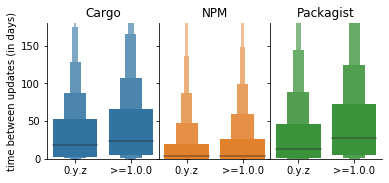

In [353]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    seaborn.boxenplot(
        y='delay',
        x='when',
        data=data[lambda d: d['ecosystem'] == ecosystem],
        order=['0.y.z', '>=1.0.0'],
        color=COLORS[ecosystem],
        ax=axes[i],
    )
    
    axes[i].set(
        title=ecosystem,
        xlabel='', 
        ylabel=''
    )

seaborn.despine(fig, top=True, right=True)
    
axes[0].set(
    xlabel='',
    ylabel='time between updates (in days)',
    ylim=(0, 180),
)

savefig(fig, 'rapid_update_delay')

In [354]:
(
    data
    .groupby(['ecosystem', ])
    ['delay']
    .describe()
    [['mean', 'std', '25%', '50%', '75%']]
)

,mean,std,25%,50%,75%
ecosystem,,,,,
Cargo,39.344550,56.147175,2.999630,19.421016,53.263438
NPM,22.836945,50.124311,0.245945,3.572329,22.700024
Packagist,49.123629,75.760579,2.835888,21.310440,63.913550


Statistical comparisons based on Mann-Whitney U and Cliff's Delta:

In [355]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '0.y.z')].delay
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['when'] == '>=1.0.0')].delay
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} before vs. after: p={:.5f}; |d|={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      before vs. after: p=0.00000; |d|=-0.084 (negligible)
NPM        before vs. after: p=0.00000; |d|=-0.027 (negligible)
Packagist  before vs. after: p=0.00000; |d|=-0.178 (small)


Between package distributions:

In [356]:
for e1, e2 in itertools.combinations(ECOSYSTEMS, r=2):
    A = data[lambda d: (d['ecosystem'] == e1)].delay
    B = data[lambda d: (d['ecosystem'] == e2)].delay
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:6} vs {:6}: p={:.5f}; |d|={:.3f} ({})'.format(e1, e2, m.pvalue, d, dl))

Cargo  vs NPM   : p=0.00000; |d|=0.319 (small)
Cargo  vs Packagist: p=0.00000; |d|=-0.030 (negligible)
NPM    vs Packagist: p=0.00000; |d|=-0.324 (small)


## How permissive are pre-1.0.0 dependency constraints?

a.k.a. "Major version zero (0.y.z) is for initial development. Anything MAY change at any time."

### Permissiveness of pre-1.0.0 constraints

Only versions released during a month are considered for this month.

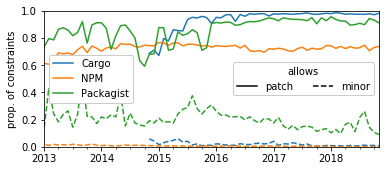

In [36]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: d['i_dev'] == True]
        .merge(
            df_releases[ecosystem][['package', 'date', 'rank']],
            how='inner',
            left_on=['source', 'rank'],
            right_on=['package', 'rank'],
        )
        .groupby(pandas.Grouper(key='date', freq='M'))
        .agg({
            'constraint': 'count',
            'i_minor': 'sum',
            'i_patch': 'sum',
        })
        .eval('minor = i_minor / constraint')
        .eval('patch = i_patch / constraint')
    )
    
    data[ecosystem][['patch', 'minor']].plot(
        color=2 * [COLORS[ecosystem]], 
        style=['-', '--'],
        legend=False,
        ax=ax
    )

legend = ax.legend(
    [patch(COLORS[ecosystem], '-') for ecosystem in ECOSYSTEMS],
    ECOSYSTEMS,
    loc='center left',
)

ax.legend(
    [patch('k', '-'), patch('k', '--')],
    ['patch', 'minor'],
    loc='center right',
    title='allows',
    ncol=2,
)

ax.add_artist(legend)

ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of constraints',
    ylim=(0, 1),
)

savefig(fig, 'stable_permissiviness')

In [37]:
_ = pandas.concat([
        data[ecosystem]
        .assign(ecosystem=ecosystem)
        for ecosystem in ECOSYSTEMS
    ], 
    axis=0
)

_.groupby('ecosystem')[['minor', 'patch']].describe().T

ecosystem        Cargo        NPM  Packagist
minor count  50.000000  97.000000  84.000000
      mean    0.019319   0.013896   0.187403
      std     0.013857   0.016603   0.107717
      min     0.003348   0.000000   0.000000
      25%     0.009698   0.004208   0.132726
      50%     0.014533   0.006679   0.181665
      75%     0.023139   0.015329   0.232919
      max     0.060491   0.069534   0.692308
patch count  50.000000  97.000000  84.000000
      mean    0.938449   0.659588   0.845698
      std     0.078535   0.149831   0.144759
      min     0.672106   0.000000   0.000000
      25%     0.949677   0.613568   0.814271
      50%     0.974620   0.721693   0.895612
      75%     0.978397   0.740266   0.924854
      max     0.987158   0.767884   1.000000

In [38]:
_.sort_index().iloc[-len(ECOSYSTEMS):]

,constraint,i_minor,i_patch,minor,patch,ecosystem
date,,,,,,
2018-12-31,93600,419.0,68503.0,0.004476,0.731870,NPM
2018-12-31,11003,40.0,10649.0,0.003635,0.967827,Cargo
2018-12-31,1489,150.0,1319.0,0.100739,0.885829,Packagist


### Focusing on the latest snapshot

In [280]:
data = pandas.concat([
    df_dependencies[ecosystem]
    .sort_values('rank')
    .drop_duplicates(['source', 'target'], keep='last')
    .assign(
        n=1,
        # Correct values, as patch superseeded by minor superseeded by major
        patch=lambda d: d['i_patch'] & ~d['i_minor'] & ~d['i_major'],
        minor=lambda d: d['i_minor'] & ~d['i_major'],
        major=lambda d: d['i_major'],
    )
    .pivot_table(index='i_dev', values=['n', 'major', 'minor', 'patch'], aggfunc='sum')
    .apply(lambda s: s / s.n, axis=1)
    .drop(columns=['n'])
    .reset_index()
    .rename(columns={'i_dev': 'kind'})
    .replace({'kind': {True: '0.y.z', False: '>=1.0.0'}})
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
    axis=0
).set_index(['ecosystem', 'kind'])

In [ ]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=2, 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, kind in enumerate(['0.y.z', '>=1.0.0']):
    (
        data
        .xs(kind, level=1)
        [['patch', 'minor', 'major']]
        .plot.bar(stacked=True, color=PAL_REL[::-1], linewidth=1, edgecolor=(0, 0, 0, 0.3), legend=False, ax=axes[i])
    )
    
    axes[i].set(
        title='target is {}'.format(kind),
        xlabel='', 
        ylabel=''
    )
    axes[i].xaxis.set_tick_params(rotation=0)

positions = [
    ((0.40, 0.95), (0.05, 0.45, 0.95)),
    ((0.40, 0.78), (0.05, 0.45, 0.89)),
    ((0.40, 0.82), (0.05, 0.45, 0.84)),
]
for i, ecosystem in enumerate(ECOSYSTEMS):
    for j, kind in enumerate(['0.y.z', '>=1.0.0']):
        for k, release in enumerate(['patch', 'minor', 'major']):
            value = data.loc[ecosystem, kind][release]
            if kind == '0.y.z' and release == 'major':
                continue
            axes[j].annotate('{:.1%}'.format(value), (i + 0.03, positions[i][j][k]), ha='center', va='center')
    
axes[0].legend(
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(1, -0.32),
)

seaborn.despine(fig, top=True, right=True)

axes[0].set(
    xlabel='',
    ylabel='prop. of constraints',
    ylim=(0, 1),
)

savefig(fig, 'stable_snapshot')

In [41]:
data.T

ecosystem     Cargo                 NPM           Packagist          
kind        >=1.0.0     0.y.z   >=1.0.0     0.y.z   >=1.0.0     0.y.z
major      0.093905  0.000000  0.040975  0.000000  0.102170  0.000000
minor      0.874108  0.011926  0.761615  0.005434  0.672813  0.182107
patch      0.027988  0.960552  0.055290  0.734251  0.130111  0.733719

## To what extent are 0.y.z packages used by other packages?

a.k.a. "If your software is being used in production, it should probably already be 1.0.0. If you have a stable API on which users have come to depend, you should be 1.0.0."

### Number of dependents for required packages above and below 1.0.0

Only the last snapshot of each ecosystem is considered. 

Only packages with at least one reverse dependency are considered.

In [46]:
data = pandas.concat([
    df_dependencies[ecosystem]
    .sort_values('rank')
    .drop_duplicates('source', keep='last')
    .groupby(['target', 'i_dev'], sort=False, as_index=False)
    [['source']]
    .count()
    .assign(ecosystem=ecosystem)
    .replace({'i_dev': {True: '0.y.z', False: '>=1.0.0'}})
    for ecosystem in ECOSYSTEMS
], axis=0)

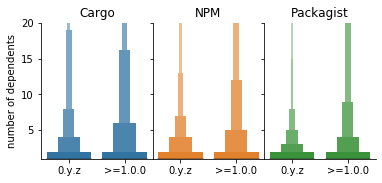

In [47]:
fig, axes = matplotlib.pyplot.subplots(
    ncols=len(ECOSYSTEMS), 
    sharex=False, 
    sharey=True,
    gridspec_kw=dict(wspace=0)
)

for i, ecosystem in enumerate(ECOSYSTEMS):
    seaborn.boxenplot(
        y='source',
        x='i_dev',
        data=data[lambda d: d['ecosystem'] == ecosystem],
        order=['0.y.z', '>=1.0.0'],
        color=COLORS[ecosystem],
        ax=axes[i],
    )
    
    axes[i].set(
        title=ecosystem,
        xlabel='', 
        ylabel=''
    )

seaborn.despine(fig, top=True, right=True)
    
axes[0].set(
    xlabel='',
    ylabel='number of dependents',
    ylim=(1, 20),
)

savefig(fig, 'usage_dependents')

In [48]:
(
    data
    .groupby(['ecosystem', 'i_dev'])
    [['source']]
    .describe()
    .T
)

ecosystem           Cargo                       NPM                \
i_dev               0.y.z     >=1.0.0         0.y.z       >=1.0.0   
source count  2395.000000  478.000000  31188.000000  47385.000000   
       mean      4.578706    8.548117      3.995415      9.154838   
       std      26.522700   40.139129     40.258364    141.980004   
       min       1.000000    1.000000      1.000000      1.000000   
       25%       1.000000    1.000000      1.000000      1.000000   
       50%       1.000000    1.000000      1.000000      1.000000   
       75%       2.000000    2.000000      2.000000      2.000000   
       max     959.000000  459.000000   3553.000000  17122.000000   

ecosystem       Packagist                
i_dev               0.y.z       >=1.0.0  
source count  3483.000000  13686.000000  
       mean      2.108240      6.769619  
       std       4.435516     85.630391  
       min       1.000000      1.000000  
       25%       1.000000      1.000000  
       50%       1.000000      1.000000  
       75%       2.000000      2.000000  
       max      91.000000   5514.000000

In [49]:
for ecosystem in ECOSYSTEMS:
    A = data[lambda d: (d['ecosystem'] == ecosystem) & (d['i_dev'] == '0.y.z')].source
    B = data[lambda d: (d['ecosystem'] == ecosystem) & (d['i_dev'] == '>=1.0.0')].source
    m = mannwhitneyu(A, B)
    d, dl = cliffsDelta(A, B)
    
    print('{:10} before vs. after: p={:.5f}; |d|={:.3f} ({})'.format(ecosystem, m.pvalue, d, dl))

Cargo      before vs. after: p=0.00561; |d|=-0.062 (negligible)
NPM        before vs. after: p=0.00000; |d|=-0.063 (negligible)
Packagist  before vs. after: p=0.00000; |d|=-0.097 (negligible)


### Dependencies between 0.y.z and >=1.0.0 packages

Only the latest snapshot is considered. 

In [50]:
data = pandas.concat([
    df_dependencies[ecosystem]
    [['source', 'target', 'rank', 'i_dev']]
    .merge(
        df_releases[ecosystem].sort_values('rank').drop_duplicates('package', keep='last')[['package', 'major', 'rank']],
        how='inner',
        left_on=['source', 'rank'],
        right_on=['package', 'rank'],
    )
    .drop(columns=['package'])
    .assign(source_kind=lambda d: pandas.np.where(d['major'] < 1.0, '0.y.z', '>=1.0.0'))
    .assign(target_kind=lambda d: pandas.np.where(d['i_dev'], '0.y.z', '>=1.0.0'))
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'source', 'target', 'source_kind', 'target_kind']]
    for ecosystem in ECOSYSTEMS],
    axis=0
)

In [51]:
pandas.concat([
    data[data['ecosystem'] == ecosystem].pipe(lambda df:
        pandas.crosstab([df.ecosystem, df.source_kind], df.target_kind, normalize='all')
    )
    for ecosystem in ECOSYSTEMS
], axis=0)

target_kind               0.y.z   >=1.0.0
ecosystem source_kind                    
Cargo     0.y.z        0.677346  0.242499
          >=1.0.0      0.050597  0.029558
NPM       0.y.z        0.127652  0.343802
          >=1.0.0      0.087050  0.441497
Packagist 0.y.z        0.047687  0.247109
          >=1.0.0      0.025827  0.679378

### Grouped by (source, target) packages.

In [52]:
data = pandas.concat([
    df_dependencies[ecosystem]
    [['source', 'target', 'rank', 'i_dev']]
    .merge(
        (
            df_releases[ecosystem]
            .drop_duplicates('package', keep='last')
            .assign(source_pre=lambda d: d['major'] < 1.0)
            [['package', 'rank', 'source_pre']]
        ),
        how='inner',
        left_on=['source', 'rank'],
        right_on=['package', 'rank'],
    )
    #.drop(columns=['package'])
    #.merge(
    #    (
    #        df_releases[ecosystem]
    #        .drop_duplicates('package', keep='last')
    #        .assign(target_pre=lambda d: d['major'] < 1.0)
    #        [['package', 'target_pre']]
    #    ),
    #    how='inner',
    #    left_on=['target'],
    #    right_on=['package'],
    #)
    .assign(target_pre=lambda d: d['i_dev'])
    .drop(columns=['package', 'rank', 'i_dev'])
    .assign(ecosystem=ecosystem)
    for ecosystem in ECOSYSTEMS],
    axis=0
)

In [53]:
ndata = []

for ecosystem in ECOSYSTEMS:
    dependents = (
        data
        [lambda d: d['ecosystem'] == ecosystem]
        .groupby(['source'], sort=False, as_index=False)
        .agg({'source_pre': 'first', 'target_pre': 'max'})
    )
    required = (
        data
        [lambda d: d['ecosystem'] == ecosystem]
        .groupby(['target'], sort=False, as_index=False)
        .agg({'source_pre': 'min', 'target_pre': 'first'})
    )
    
    for source in [True, False]:
        for target in [True, False]:
            sources = len(dependents[lambda d: (d['source_pre'] == source) & (d['target_pre'] == target)])
            targets = len(required[lambda d: (d['source_pre'] == source) & (d['target_pre'] == target)])
            ndata.append((
                ecosystem,
                '0.y.z' if source else '>=1.0.0',
                '0.y.z' if target else '>=1.0.0',
                sources,
                sources / len(dependents),
                targets,
                targets / len(required),
            ))
        
ndata = pandas.DataFrame(columns=['ecosystem', 'source', 'target', 'sources', 'p_sources', 'targets', 'p_targets'], data=ndata)

In [54]:
(
    ndata
    .pivot_table(index=['ecosystem', 'source'], columns=['target'], values=['p_sources', 'p_targets'], aggfunc='first')
    .style.format('{:.1%}').background_gradient(axis=None)
)